In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the packages
import numpy as np
import pandas as pd
#import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
import warnings
warnings.simplefilter(action = "ignore")
sns.set()
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
df_d=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/diabetescleaned.csv')
df_h=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/heartcleaned.csv')
df_k=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/kidneycleaned.csv')
df_l=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/livercleaned.csv')

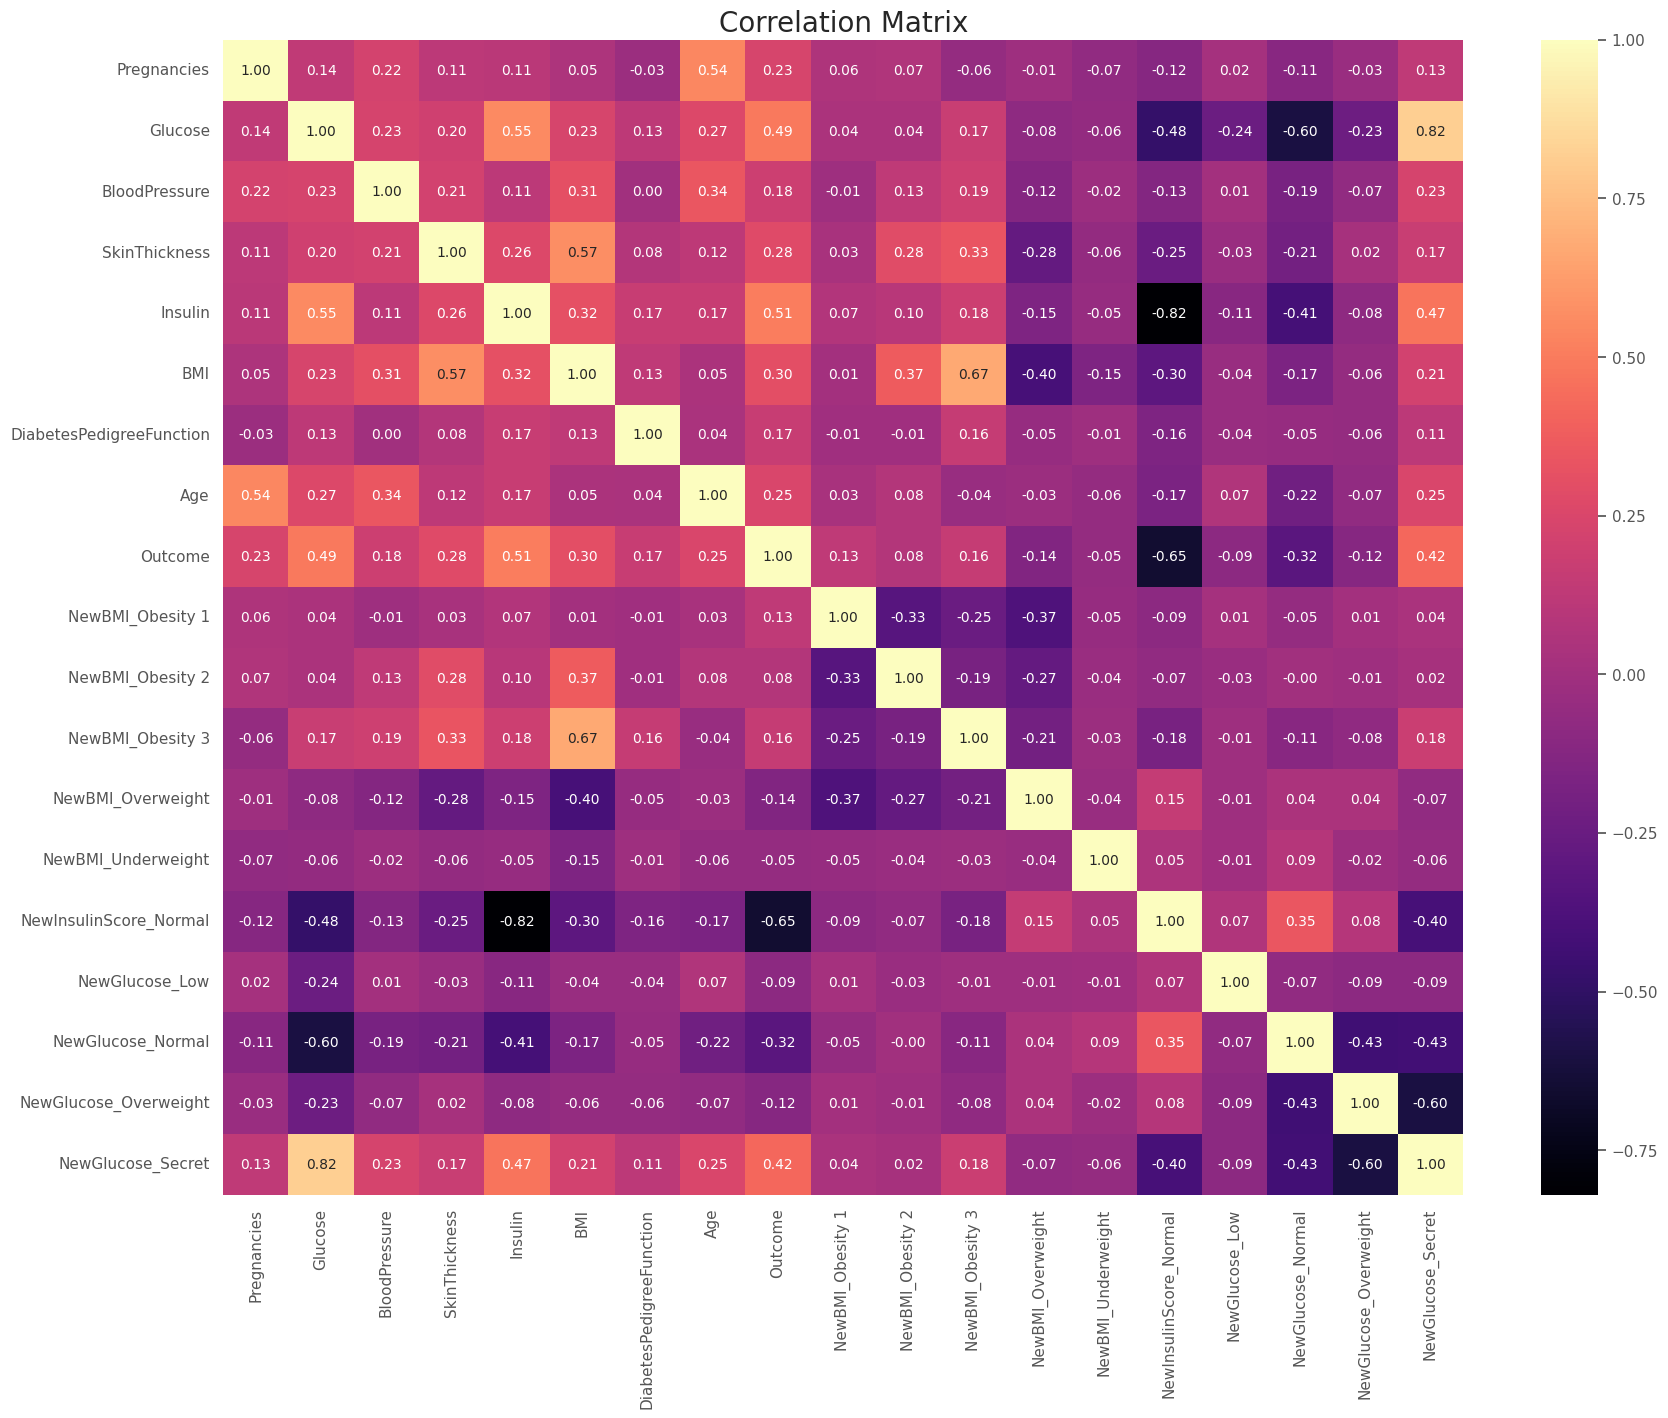

In [ ]:
# Correlation matrix of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_d.corr(), annot=True, fmt=".2f", ax=ax, cmap ='magma' )
ax.set_title("Correlation Matrix", fontsize=20)
#plt.savefig("corr.png", dpi=400)
plt.show()

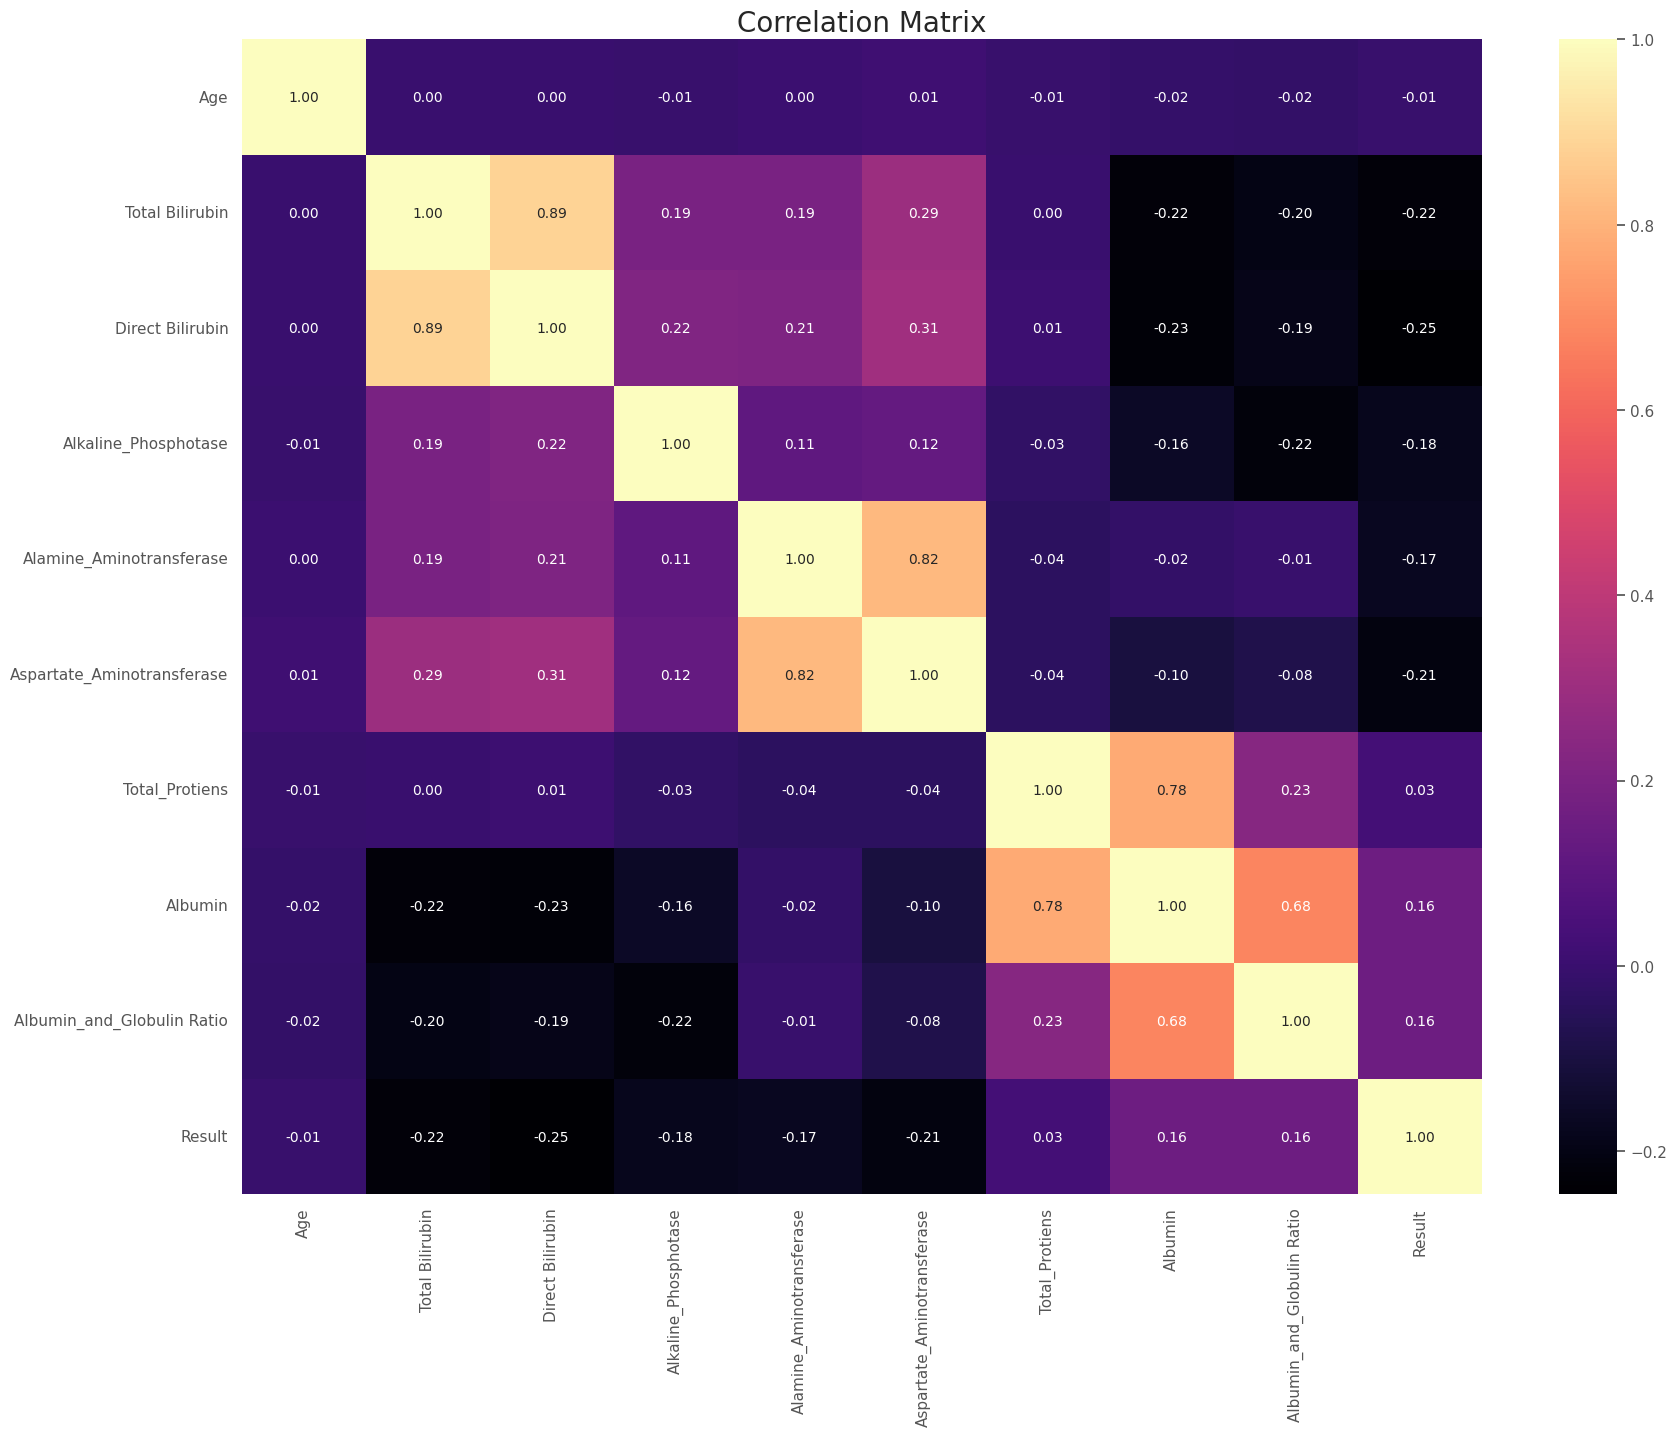

In [ ]:
# Correlation matrix of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_l.corr(), annot=True, fmt=".2f", ax=ax, cmap ='magma' )
ax.set_title("Correlation Matrix", fontsize=20)
#plt.savefig("corr.png", dpi=400)
plt.show()

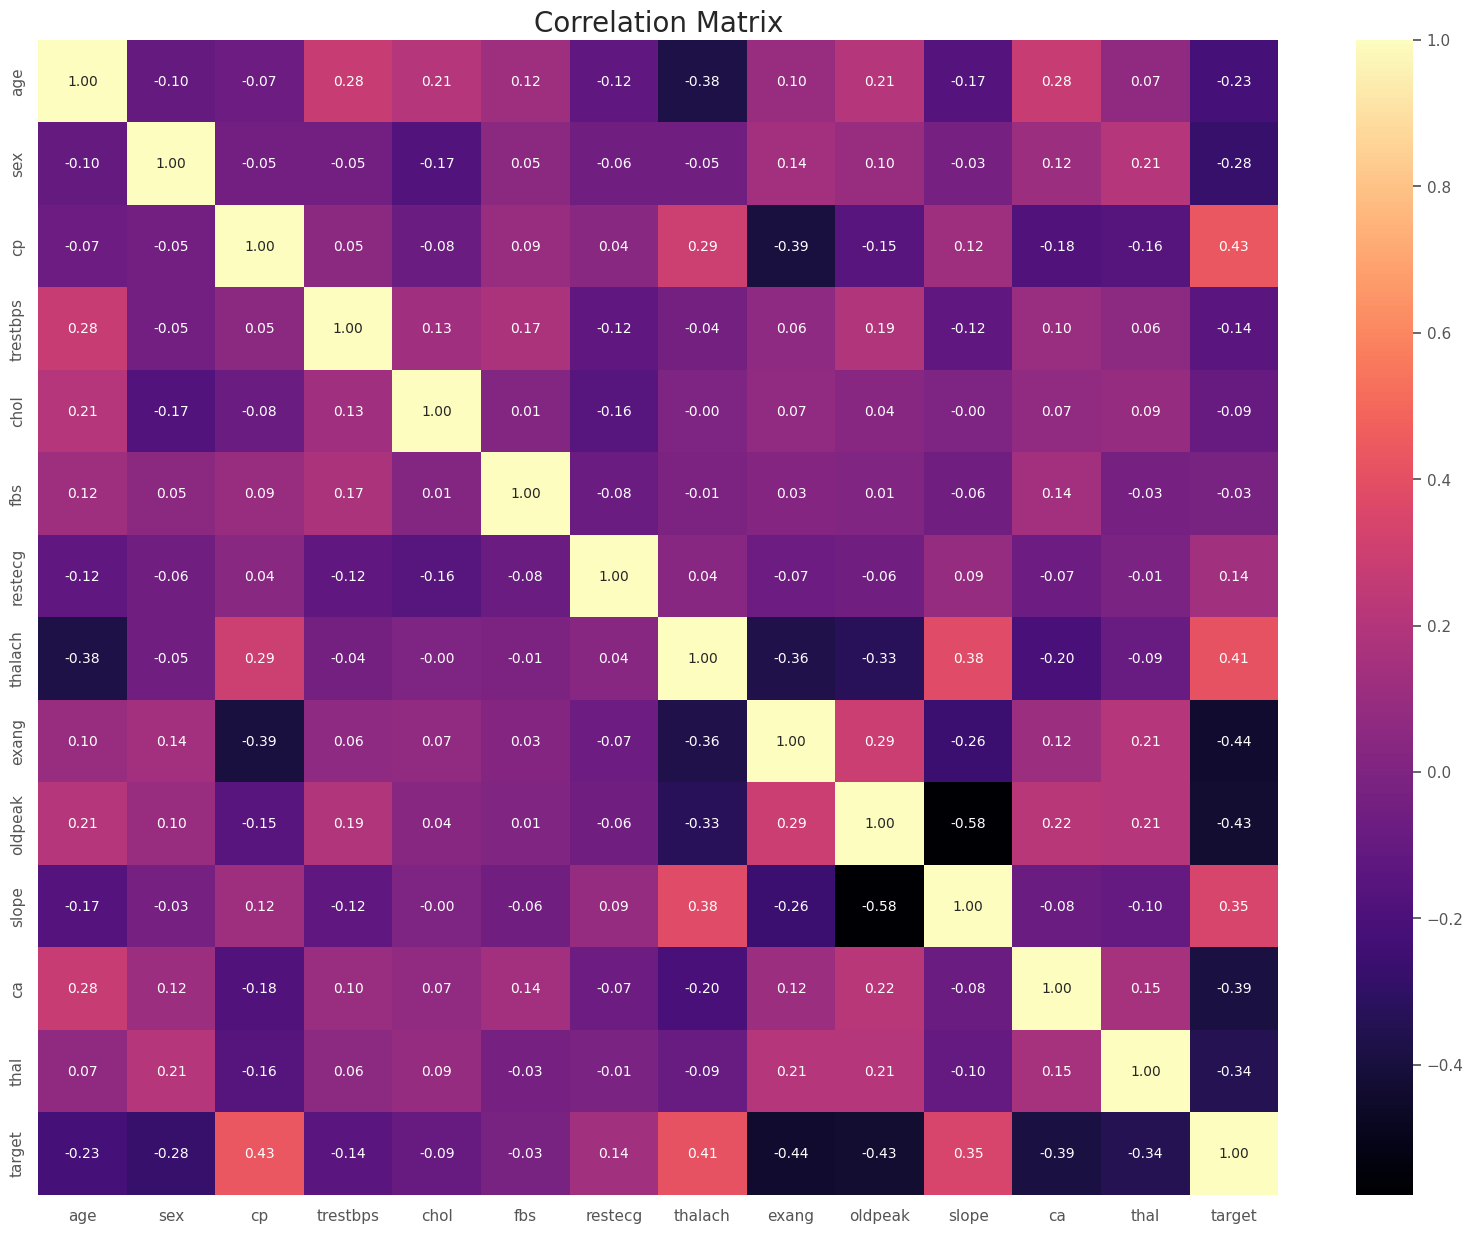

In [ ]:
# Correlation matrix of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_h.corr(), annot=True, fmt=".2f", ax=ax, cmap ='magma' )
ax.set_title("Correlation Matrix", fontsize=20)
#plt.savefig("corr.png", dpi=400)
plt.show()

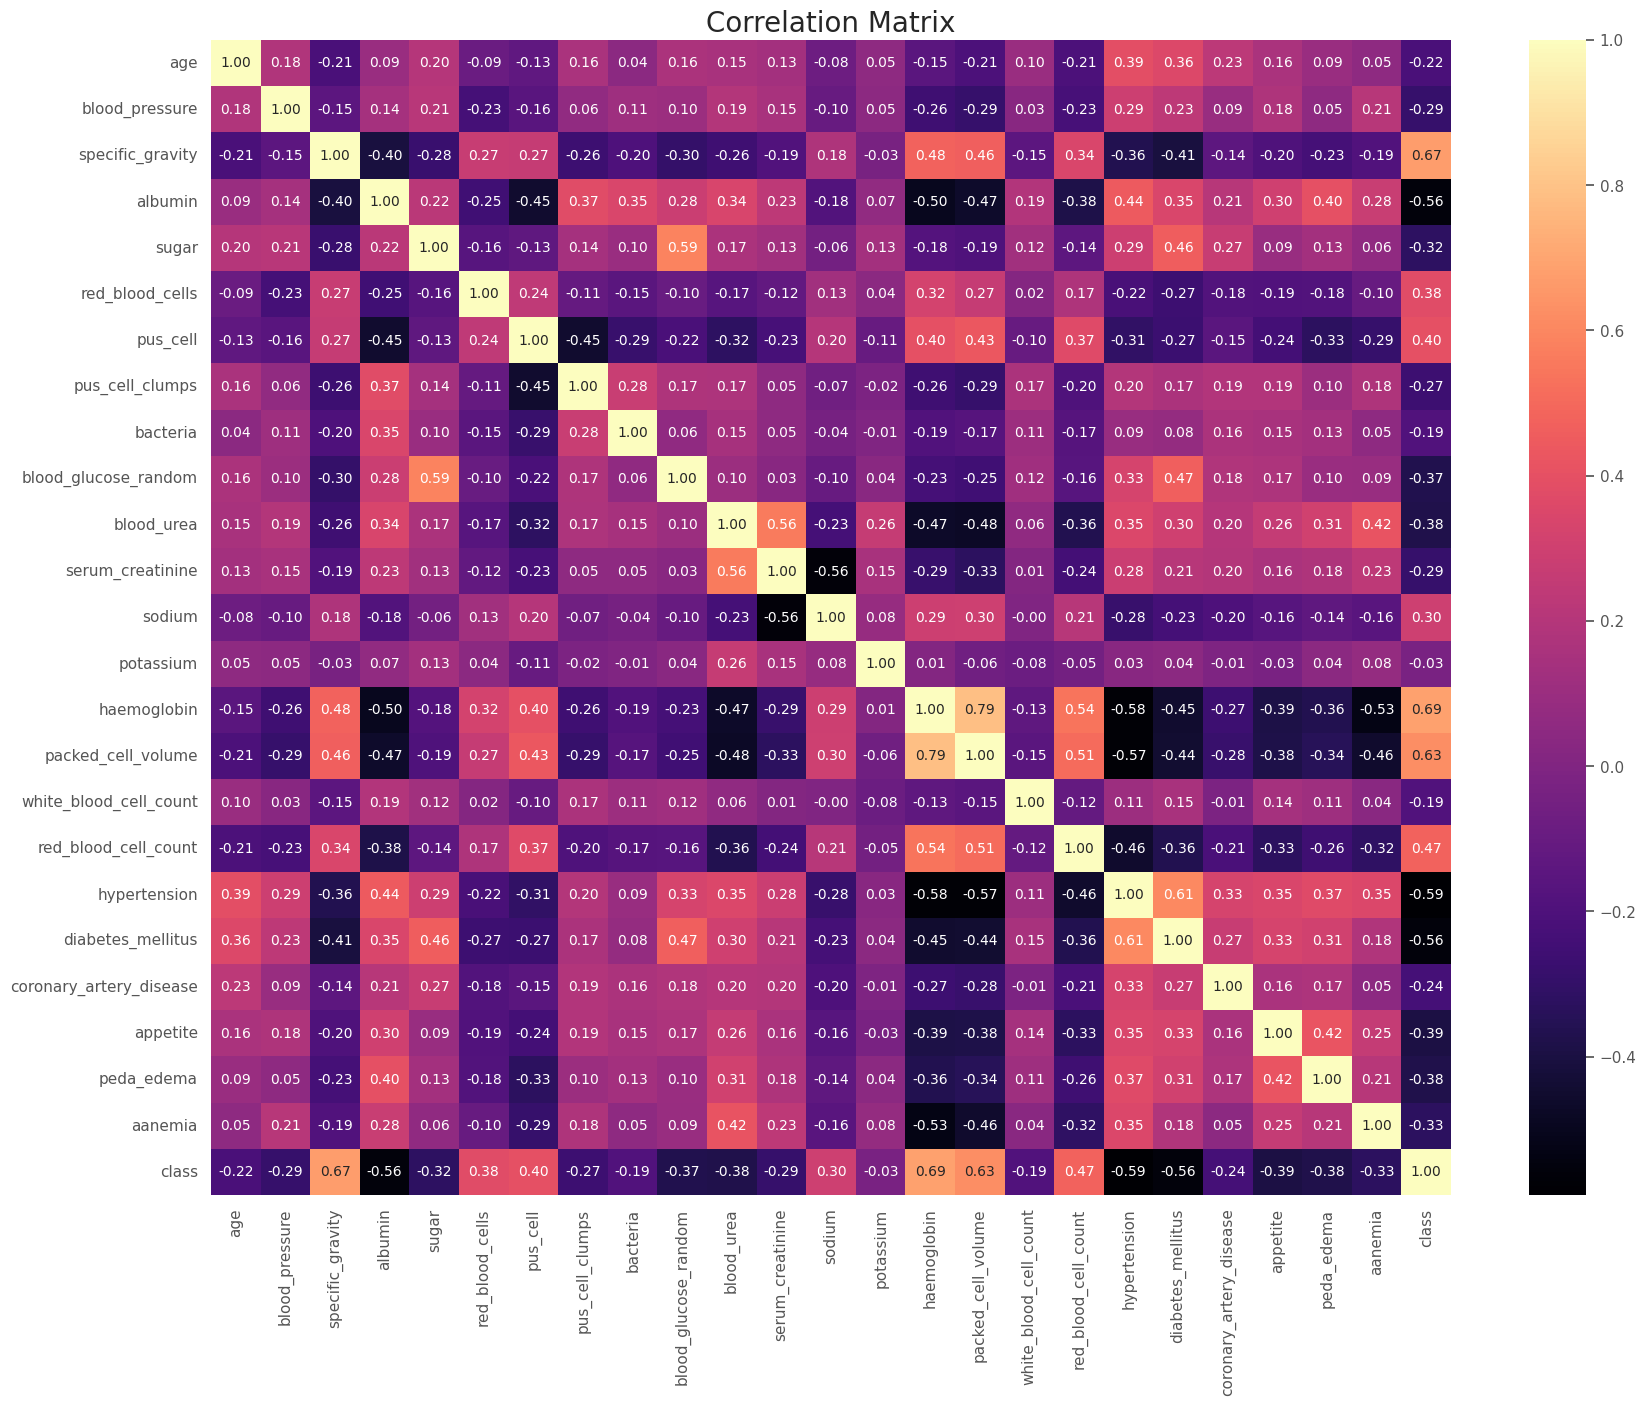

In [ ]:
# Correlation matrix of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_k.corr(), annot=True, fmt=".2f", ax=ax, cmap ='magma' )
ax.set_title("Correlation Matrix", fontsize=20)
#plt.savefig("corr.png", dpi=400)
plt.show()

In [ ]:
newdf_h = df_h.drop(['trestbps', 'chol', 'fbs', 'restecg', 'slope'], axis=1, inplace=False)

In [ ]:
newdf_d = df_d.drop(['BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight', 'NewBMI_Underweight', 'NewGlucose_Low', 'NewGlucose_Overweight'], axis=1, inplace=False)

In [ ]:
newdf_k = df_k.drop(['bacteria', 'potassium', 'white_blood_cell_count', 'pus_cell_clumps', 'serum_creatinine', 'blood_pressure', 'sodium', 'sugar', 'aanemia', 'red_blood_cells', 'blood_glucose_random', 'blood_urea', 'appetite', 'peda_edema', 'pus_cell', 'red_blood_cell_count'], axis=1, inplace=False)

In [ ]:
newdf_l = df_l.drop(['Total_Protiens', 'Albumin'], axis=1, inplace=False)

In [ ]:
## if score==negative, mark 0 ;else 1
def partition(x):
    if x =='Male':
        return 0
    return 1

newdf_l['Gender'] = newdf_l['Gender'].map(partition)

In [ ]:
newdf_d.head(10)

,Pregnancies,Glucose,Insulin,BMI,Age,Outcome,NewInsulinScore_Normal,NewGlucose_Normal,NewGlucose_Secret
0,6,148.0,169.5,33.6,50,1,0,0,1
1,1,85.0,102.5,26.6,31,0,1,1,0
2,8,183.0,169.5,23.3,32,1,0,0,1
3,1,89.0,94.0,28.1,21,0,1,1,0
4,0,137.0,168.0,43.1,33,1,0,0,1
5,5,116.0,102.5,25.6,30,0,1,0,0
6,3,78.0,88.0,31.0,26,1,1,1,0
7,10,115.0,102.5,35.3,29,0,1,0,0
8,2,197.0,270.0,30.5,53,1,0,0,1
9,8,125.0,169.5,34.3,54,1,0,0,0


In [ ]:
# Split the data into training and testing sets
X_diabetes, X_test_diabetes, y_diabetes, y_test_diabetes = train_test_split(newdf_d.drop('Outcome', axis=1), newdf_d['Outcome'], test_size=0.2, random_state=42)
X_heart, X_test_heart, y_heart, y_test_heart = train_test_split(newdf_h.drop('target', axis=1), newdf_h['target'], test_size=0.2, random_state=42)
X_kidney, X_test_kidney, y_kidney, y_test_kidney = train_test_split(newdf_k.drop('class', axis=1), newdf_k['class'], test_size=0.2, random_state=42)
X_liver, X_test_liver, y_liver, y_test_liver = train_test_split(newdf_l.drop('Result', axis=1), newdf_l['Result'], test_size=0.2, random_state=42)

In [ ]:
# Create the individual models
diabetes_model = RandomForestClassifier()
heart_model = RandomForestClassifier()
kidney_model = RandomForestClassifier()
liver_model = RandomForestClassifier()

In [ ]:
# Train the individual models
diabetes_model.fit(X_diabetes, y_diabetes)
heart_model.fit(X_heart, y_heart)
kidney_model.fit(X_kidney, y_kidney)
liver_model.fit(X_liver, y_liver)

RandomForestClassifier()

In [ ]:
# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('diabetes', diabetes_model), ('heart', heart_model), ('kidney', kidney_model), ('liver', liver_model)], voting='hard')

In [ ]:
# Train the ensemble model
ensemble_model.fit(np.concatenate((X_diabetes, X_heart, X_kidney, X_liver), axis=0), np.concatenate((y_diabetes, y_heart, y_kidney, y_liver), axis=0))

VotingClassifier(estimators=[('diabetes', RandomForestClassifier()),
                             ('heart', RandomForestClassifier()),
                             ('kidney', RandomForestClassifier()),
                             ('liver', RandomForestClassifier())])

In [ ]:
# Evaluate the ensemble model
accuracy = accuracy_score(np.concatenate((y_test_diabetes, y_test_heart, y_test_kidney, y_test_liver), axis=0), ensemble_model.predict(np.concatenate((X_test_diabetes, X_test_heart, X_test_kidney, X_test_liver), axis=0)))
print('Accuracy:', accuracy)

Accuracy: 0.9947442186405046


In [ ]:
import pickle

# Save the trained ensemble model to a file
with open('/content/ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)


In [ ]:
# Load the saved model from file
import pickle
with open('ensemble_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
def predict_disease(disease_type, **kwargs):
    with open('ensemble_model.pkl', 'rb') as f:
        ensemble_model = pickle.load(f)

    if disease_type == 'heart':
        features = np.array([[kwargs.get('age'), kwargs.get('sex'), kwargs.get('cp'), kwargs.get('thalach'),
                              kwargs.get('exang'), kwargs.get('oldpeak'), kwargs.get('ca'), kwargs.get('thal')]])
    elif disease_type == 'diabetes':
        features = np.array([[kwargs.get('Pregnancies'), kwargs.get('Glucose'), kwargs.get('Insulin'), kwargs.get('BMI'),
                              kwargs.get('Age'), kwargs.get('NewInsulinScore_Normal'), kwargs.get('NewGlucose_Normal'),
                              kwargs.get('NewGlucose_Secret')]])
    elif disease_type == 'liver':
        features = np.array([[kwargs.get('Age'), kwargs.get('Gender'), kwargs.get('Total_Bilirubin'),
                              kwargs.get('Direct_Bilirubin'), kwargs.get('Alkaline_Phosphotase'),
                              kwargs.get('Alamine_Aminotransferase'), kwargs.get('Aspartate_Aminotransferase'),
                              kwargs.get('Albumin_and_Globulin_Ratio')]])
    elif disease_type == 'kidney':
        features = np.array([[kwargs.get('age'), kwargs.get('specific_gravity'), kwargs.get('albumin'),
                              kwargs.get('haemoglobin'), kwargs.get('packed_cell_volume'),
                              kwargs.get('hypertension'), kwargs.get('diabetes_mellitus'),
                              kwargs.get('coronary_artery_disease')]])
    else:
        return "Invalid disease type"

    prediction = ensemble_model.predict(features)
    return prediction[0]

# Call the function to predict heart disease
prediction = predict_disease(disease_type='heart', age=63, sex=1, cp=3, thalach=5.01, exang=0, oldpeak=2.3, ca=0, thal=1)
print("Predicted heart disease status:", prediction)

# Call the function to predict diabetes
prediction = predict_disease(disease_type='diabetes', Pregnancies=6, Glucose=148, Insulin=169, BMI=33.6, Age=50,
                             NewInsulinScore_Normal=0, NewGlucose_Normal=0, NewGlucose_Secret=1)
print("Predicted Diabetes disease status:", prediction)

# Call the function to predict liver disease
prediction = predict_disease(disease_type='liver', Age=65, Gender=1, Total_Bilirubin=0.7, Direct_Bilirubin=0.1,
                             Alkaline_Phosphotase=187, Alamine_Aminotransferase=16, Aspartate_Aminotransferase=18,
                             Albumin_and_Globulin_Ratio=0.90)
print("Predicted Liver disease status:", prediction)

# Call the function to predict kidney disease
prediction = predict_disease(disease_type='kidney', age=52, specific_gravity=1.025, albumin=0.0, haemoglobin=15,
                             packed_cell_volume=52, hypertension=0, diabetes_mellitus=0, coronary_artery_disease=0)
print("Predicted Kidney disease status:", prediction)


Predicted heart disease status: 1
Predicted Diabetes disease status: 1
Predicted Liver disease status: 1
Predicted Kidney disease status: 1
